In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

Read Fairlearn results

In [59]:
dataset = 'german_binary'
data = 'adult' if dataset == 'limited-adult-2' else dataset
df = pd.read_csv(f'fairlearn/{data}_results.csv')

In [62]:
for i in ['test_acc', 'test_disp', 'train_acc', 'train_disp']:
    df[i] = round(df[i], 2)

In [63]:
g = df[(df['method'] == 'gridsearch')][['classifier', 'metric', 'test_acc', 'test_disp',
                                    'train_acc', 'train_disp', 'hyp']].groupby(['classifier', 'metric', 'hyp']).agg(list)

Read FlowOCT results

In [64]:
def consolidate(row, t):
    if row['fair type'] == 'EOdds':
        return row[f'EOdds {t} pred']
    elif row['fair type'] == 'SP':
        return row[f'sp {t} pred']
    elif row['fair type'] == 'CSP':
        return row[f'csp {t} pred']
    elif row['fair type'] == 'EOpp':
        return row[f'EOpp {t} pred']
    elif row['fair type'] == 'PE':
        return row[f'pe {t} pred']

In [65]:
header = pd.read_csv('fairoct_results/header.csv')
header = header.rename(columns={' EOdds train pred': 'EOdds train pred'})
flowoct = pd.read_csv(f'fairoct_results/FlowOCT_{dataset}.csv', 
                      header=None, names=list(header.columns))

In [66]:
if dataset != 'german_binary':
    flowoct1 = pd.read_csv(f'fairoct_results/{dataset}.csv', 
                          header=None, names=list(header.columns))
    flowoct = pd.concat([flowoct, flowoct1])

In [67]:
flowoct['test_disp'] = flowoct.apply(lambda row: consolidate(row, 'test'), axis=1)
flowoct['train_disp'] = flowoct.apply(lambda row: consolidate(row, 'train'), axis=1)
flowoct = flowoct[flowoct['fair type'] != 'None']
flowoct_avg = flowoct[['fair type', 
         'fair bound', 'depth',
         'test acc', 
         'test_disp', 'train acc',
                      'train_disp']].groupby(['fair type', 'fair bound', 'depth']).agg('mean').reset_index()
flowoct_avg = flowoct_avg.rename(columns={'fair bound': 'hyp', 'test acc': 'test_acc', 'train acc': 'train_acc'})
flowoct_avg['classifier'] = flowoct_avg['depth'].apply(lambda x: f'Full Tree (d={x})')

Read Kamiran Data

In [68]:
header = pd.read_csv('kamiran_results/header.csv')

In [69]:
data = dataset if dataset != 'german_binary' else 'german'

In [70]:
mets = ['igc+igs_relab']
for m in mets:
    kamiran = pd.read_csv(f'kamiran_results/final/{m}/{data}.csv',header=None, names=list(header.columns))

In [71]:
kamiran = kamiran.rename(columns={'fair bound': 'hyp', 'test acc': 'test_acc', 'train acc': 'train_acc',
                                 'sp train pred': 'train_disp', 'sp test pred': 'test_disp'})
kamiran['method'] = 'DADT (IGC+IGS_Relab)'
kamiran['classifier'] = 'DT'
kamiran['metric'] = 'DP'

In [72]:
kamiran['test_acc'] = kamiran['test_acc']/100
kamiran['train_acc'] = kamiran['train_acc']/100

In [73]:
kamiran['test_disp'] = np.abs(kamiran['test_disp'])
kamiran['train_disp'] = np.abs(kamiran['train_disp'])

Read DIDI

In [74]:
didi = pd.read_csv(f'DIDI_results/{dataset}.csv')

In [75]:
didi = didi.rename(columns={'lambda': 'hyp', 'test_pred_sp': 'test_disp', 'train_pred_sp': 'train_disp'})
didi['classifier'] = didi['depth'].apply(lambda x: f'Full Tree (d={x})')
didi['method'] = 'RegOCT'
didi['metric'] = 'DP'

In [77]:
d=3
if d == 1:
    classifier_xwalk = {'Full Tree': 0, 'DT': 1, 'LR': 2, 'SVM': 3, 'RF': 5, 'KNN': 4, 'MLP': 6}
elif d == 3:
    classifier_xwalk = {'Full Tree (d=1)': 0, 'Full Tree (d=2)': 1, 'Full Tree (d=3)': 2,
                        'DT': 4, 'LR': 3, 'SVM': 6, 'RF': 8, 'KNN': 5, 'MLP': 7}

In [78]:
xwalk = {'DP': 'SP', 'EO': 'EOdds', 'TPR': 'EOpp', 'FPR': 'PE'}
reverse_xwalk = {j: i for i, j in classifier_xwalk.items()}

In [79]:
cmap = sns.color_palette("rocket", as_cmap=True)

In [80]:
import matplotlib

In [81]:
agg = True
yticks = None
if dataset == 'limited-adult-2':
    xlim = [-0.02, 0.4]
    ylim = [0.7, 0.85]
    xticks = [0, 0.1, 0.2, 0.3]
elif dataset == 'compas':
    xlim = [-0.02, 0.5]
    ylim = [0.4, 0.7]
    xticks = [0, 0.2, 0.4]
    yticks = [0.4, 0.5, 0.6, 0.7]
elif dataset == 'german_binary':
    xlim = [-0.02, 0.33]
    ylim = [0.5, 0.8]
    xticks = [0, 0.1, 0.2, 0.3]
    yticks = [0.5, 0.6, 0.7, 0.8]
matplotlib.rcParams.update({'font.size': 20})

In [82]:
title_xwalk = {'DP': 'Statistical Parity', 'EO': 'Equalized Odds', 'TPR': 'Equal Opportunity', 
               'FPR': 'Predictive Equality'}

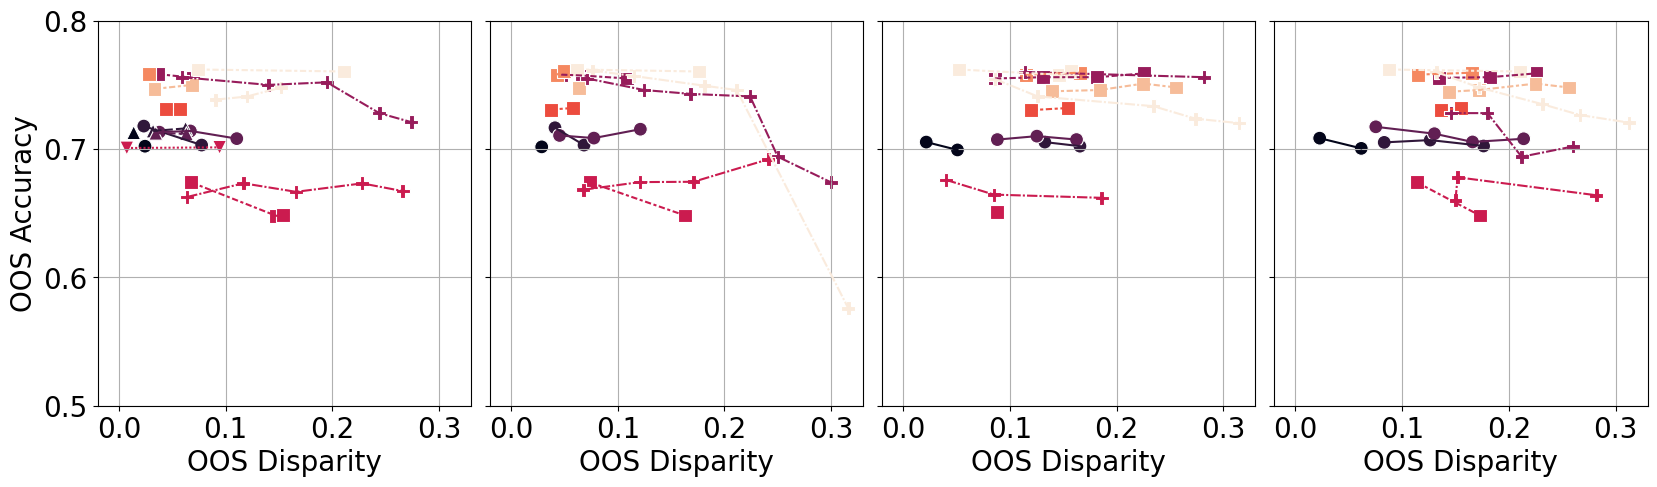

In [83]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i, a in zip(df['metric'].unique(), [ax1, ax2, ax3, ax4]):
    subset = df[df['metric'] == i]
    subset_oct = flowoct_avg[flowoct_avg['fair type'] == xwalk[i]].drop(columns=['fair type'])
    subset_oct['method'] = 'FairOCT'
    if i == 'DP':
        subset = pd.concat([subset, subset_oct, kamiran[['hyp', 'test_acc', 'test_disp', 
                                                         'method', 'classifier', 'metric']],
                           didi[['hyp', 'test_acc', 'test_disp', 
                                                         'method', 'classifier', 'metric']]], ignore_index=True)
    else:
        subset = pd.concat([subset, subset_oct], ignore_index=True)
    subset['classifier_num'] = subset['classifier'].apply(lambda x: classifier_xwalk[x])
    subset = subset[['test_acc', 'test_disp', 
                     'classifier_num', 'method', 
                     'hyp']].groupby(['classifier_num', 'method', 'hyp']).agg('mean').reset_index()
    
    if agg:
        # aggregate by increment 0.05
        agg_df = pd.DataFrame(columns=['classifier_num', 'method', 'test_acc', 'test_disp'])
        for m in subset['method'].unique():
            for c in subset['classifier_num'].unique():
                subset2 = subset[(subset['method'] == m) & (subset['classifier_num'] == c)]
                if not subset2.empty:
                    start = 0
                    inc = 0.05
                    end = start + inc

                    while end < 1:
                        s1 = subset2[(subset2['test_disp'] >= start) & (subset2['test_disp'] < end)]
                        agg_df.loc[len(agg_df)] = [c, m, s1['test_acc'].mean(), s1['test_disp'].mean()]

                        end += inc
                        start += inc
        if i != 'DP':
            agg_df.loc[len(agg_df)] = [3, 'DADT (IGC+IGS_Relab)', np.nan, np.nan]
    else:
        agg_df = subset
        if i != 'DP':
            agg_df.loc[len(agg_df)] = [3, 'DADT (IGC+IGS_Relab)', np.nan, np.nan, np.nan]
        
    upper_x = xlim[1]
    # cut everything that's above upper_x
    agg_df = agg_df[agg_df['test_disp'] < upper_x]
    
    sns.lineplot(data=agg_df, x='test_disp', y='test_acc', hue='classifier_num', style='method', 
                 ax=a, palette=cmap, legend="full",
                style_order=['FairOCT', 'RegOCT', 'DADT (IGC+IGS_Relab)', 'correlation_remover', 'gridsearch',
                            'threshold_optimizer'])
    
    sns.scatterplot(data=agg_df, x='test_disp', y='test_acc', hue='classifier_num', style='method', 
                 ax=a, markers=["o", "^", "v", "s", 'P', 'X'], palette=cmap, legend="full",
                style_order=['FairOCT', 'RegOCT', 'DADT (IGC+IGS_Relab)', 'correlation_remover', 'gridsearch',
                            'threshold_optimizer'], s=100)

    a.set_xlim(xlim)
    if yticks is not None:
        a.set_yticks(yticks)
    a.set_xticks(xticks)
    a.set_ylim(ylim)
#     if i == 'EO':
#         h,l = a.get_legend_handles_labels()
#         thres = len(classifier_xwalk)+1
#         l1 = a.legend(h[:thres],['Classifier']+[reverse_xwalk[i] for i in range(thres-1)], bbox_to_anchor=(1.2, 1.2), ncol=3)
#         l2 = a.legend(h[thres:],['Fairness Method']+['FairOCT', 'RegOCT', 'DADT', 'CR', 'ExpG', 'RTO'], bbox_to_anchor=(2.6, 0.3), ncol=2)
#         a.add_artist(l1)
# #         a.legend(bbox_to_anchor=(1.5, 0.5))
#     else:
#         leg = a.get_legend()
#         leg.remove()
    
    if i == 'DP':
        a.set_ylabel('OOS Accuracy')
        
    a.set_xlabel('OOS Disparity')
    leg = a.get_legend()
    leg.remove()
#     a.set_title(title_xwalk[i])
    a.grid()
plt.subplots_adjust(wspace=0.05)
plt.savefig('german.pdf', bbox_inches='tight')
plt.show()

## just CSP for FairOCT

In [52]:
xlim = [-0.02, 0.4]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

In [13]:
subset = flowoct_avg[flowoct_avg['fair type'] == 'CSP'].drop(columns=['fair type'])

In [15]:
subset['method'] = 'FairOCT'

In [24]:
subset['classifier_num'] = subset['classifier'].apply(lambda x: classifier_xwalk[x])
subset = subset[['test_acc', 'test_disp', 
                     'classifier_num', 'method', 
                     'hyp']].groupby(['classifier_num', 'method', 'hyp']).agg('mean').reset_index()

In [53]:
if agg:
    # aggregate by increment 0.05
    agg_df = pd.DataFrame(columns=['classifier_num', 'method', 'test_acc', 'test_disp'])
    for m in subset['method'].unique():
        for c in subset['classifier_num'].unique():
            subset2 = subset[(subset['method'] == m) & (subset['classifier_num'] == c)]
            if not subset2.empty:
                start = 0
                inc = 0.05
                end = start + inc

                while end < 1:
                    s1 = subset2[(subset2['test_disp'] >= start) & (subset2['test_disp'] < end)]
                    agg_df.loc[len(agg_df)] = [c, m, s1['test_acc'].mean(), s1['test_disp'].mean()]

                    end += inc
                    start += inc

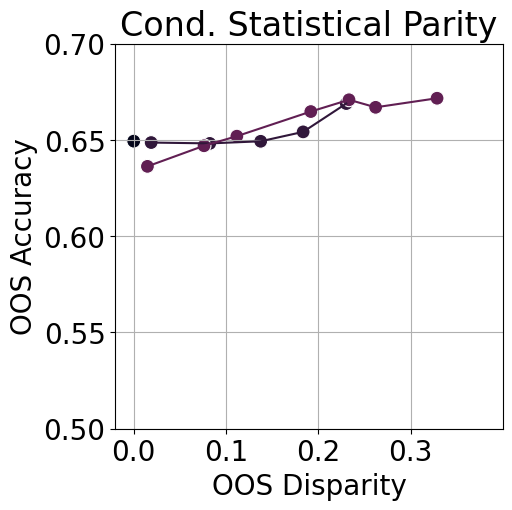

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
upper_x = xlim[1]
# cut everything that's above upper_x
agg_df = agg_df[agg_df['test_disp'] < upper_x].reset_index(drop=True)
for i in range(3, 9):
    agg_df.loc[len(agg_df)] = [i, 'FairOCT', np.nan, np.nan]

sns.lineplot(data=agg_df, x='test_disp', y='test_acc', hue='classifier_num', style='method', 
             ax=ax, palette=cmap, legend="full",
            style_order=['FairOCT'])

sns.scatterplot(data=agg_df, x='test_disp', y='test_acc', hue='classifier_num', style='method', 
             ax=ax, markers=["o"], palette=cmap, legend="full",
            style_order=['FairOCT'], s=100)

leg = ax.get_legend()
leg.remove()


ax.set_title('Cond. Statistical Parity')
ax.set_ylim([0.5, 0.7])
ax.set_xlim(xlim)
ax.set_xticks([0, 0.1, 0.2, 0.3])
ax.grid()

ax.set_ylabel('OOS Accuracy')
ax.set_xlabel('OOS Disparity')
plt.savefig('CSP.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

subset = flowoct_avg[flowoct_avg['fair type'] == 'CSP'].drop(columns=['fair type'])



for i, a in zip(df['metric'].unique(), [ax1, ax2, ax3, ax4]):
    subset = df[df['metric'] == i]
    subset_oct = flowoct_avg[flowoct_avg['fair type'] == xwalk[i]].drop(columns=['fair type'])
    subset_oct['method'] = 'FairOCT'
    if i == 'DP':
        subset = pd.concat([subset, subset_oct, kamiran[['hyp', 'test_acc', 'test_disp', 
                                                         'method', 'classifier', 'metric']],
                           didi[['hyp', 'test_acc', 'test_disp', 
                                                         'method', 'classifier', 'metric']]], ignore_index=True)
    else:
        subset = pd.concat([subset, subset_oct], ignore_index=True)
    subset['classifier_num'] = subset['classifier'].apply(lambda x: classifier_xwalk[x])
    subset = subset[['test_acc', 'test_disp', 
                     'classifier_num', 'method', 
                     'hyp']].groupby(['classifier_num', 'method', 'hyp']).agg('mean').reset_index()
    
    if agg:
        # aggregate by increment 0.05
        agg_df = pd.DataFrame(columns=['classifier_num', 'method', 'test_acc', 'test_disp'])
        for m in subset['method'].unique():
            for c in subset['classifier_num'].unique():
                subset2 = subset[(subset['method'] == m) & (subset['classifier_num'] == c)]
                if not subset2.empty:
                    start = 0
                    inc = 0.05
                    end = start + inc

                    while end < 1:
                        s1 = subset2[(subset2['test_disp'] >= start) & (subset2['test_disp'] < end)]
                        agg_df.loc[len(agg_df)] = [c, m, s1['test_acc'].mean(), s1['test_disp'].mean()]

                        end += inc
                        start += inc
        if i != 'DP':
            agg_df.loc[len(agg_df)] = [3, 'DADT (IGC+IGS_Relab)', np.nan, np.nan]
    else:
        agg_df = subset
        if i != 'DP':
            agg_df.loc[len(agg_df)] = [3, 'DADT (IGC+IGS_Relab)', np.nan, np.nan, np.nan]
        
    upper_x = xlim[1]
    # cut everything that's above upper_x
    agg_df = agg_df[agg_df['test_disp'] < upper_x]
    
    sns.lineplot(data=agg_df, x='test_disp', y='test_acc', hue='classifier_num', style='method', 
                 ax=a, markers=["o", "^", "v", "s", 'P', 'X'], palette=cmap, legend="full",
                style_order=['FairOCT', 'RegOCT', 'DADT (IGC+IGS_Relab)', 'correlation_remover', 'gridsearch',
                            'threshold_optimizer'])
    
    sns.scatterplot(data=agg_df, x='test_disp', y='test_acc', hue='classifier_num', style='method', 
                 ax=a, markers=["o", "^", "v", "s", 'P', 'X'], palette=cmap, legend="full",
                style_order=['FairOCT', 'RegOCT', 'DADT (IGC+IGS_Relab)', 'correlation_remover', 'gridsearch',
                            'threshold_optimizer'], s=100)

    a.set_xlim(xlim)
#     a.set_xticks([0, 0.1, 0.2, 0.3, 0.4])
    a.set_ylim([0.5, 0.8])
    if i == 'EO':
        h,l = a.get_legend_handles_labels()
        thres = len(classifier_xwalk)+1
        l1 = a.legend(h[:thres],['Classifier']+[reverse_xwalk[i] for i in range(thres-1)], bbox_to_anchor=(1.2, 1.2), ncol=3)
        l2 = a.legend(h[thres:],['Fairness Method']+['FairOCT', 'RegOCT', 'DADT', 'CR', 'ExpG', 'RTO'], bbox_to_anchor=(2.6, 0.3), ncol=2)
        a.add_artist(l1)
#         a.legend(bbox_to_anchor=(1.5, 0.5))
    else:
        leg = a.get_legend()
        leg.remove()
    
    if i == 'DP':
        a.set_ylabel('OOS Accuracy')
        
    a.set_xlabel('OOS Disparity')
#     leg = a.get_legend()
#     leg.remove()
    a.set_title(title_xwalk[i])
    a.grid()
plt.subplots_adjust(wspace=0.05)
plt.savefig('legend.pdf', bbox_inches='tight')
plt.show()